In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import os, time, random, gc
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from operator import itemgetter
import lightgbm as lgb

os.listdir("input")

['train.csv', 'test.csv', 'gender_submission.csv']

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

In [3]:
tr = pd.read_csv("input/train.csv")
te = pd.read_csv("input/test.csv")

In [4]:
display(tr.head())
display(te.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Features

Pclass: as CategoryType
Name: as CategoryType - split "." Mr. Miss,..    
Sex: as CategoryType   
Age: use it directly or categorize this   
SibSp:   
Parch   
Ticket: can groupby Pclass?   
Fare:    
Cabin: as Binary Category?  
Embarked: as CategoryType

# Missing value Handling

In [5]:
def missing_values_table(df):# Function to calculate missing values by column# Funct 
    mis_val = df.isnull().sum() # Total missing values
    mis_val_pct = 100 * df.isnull().sum() / len(df)# Percentage of missing values
    mis_val_df = pd.concat([mis_val, mis_val_pct], axis=1)# Make a table with the results
    mis_val_df_cols = mis_val_df.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})# Rename the columns
    mis_val_df_cols = mis_val_df_cols[mis_val_df_cols.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)# Sort the table by percentage of missing descending
    print ("Dataframe has " + str(df.shape[1]) + " columns.\n" 
           "There are " + str(mis_val_df_cols.shape[0]) + " cols having missing values.")# Print some summary information
    return mis_val_df_cols # Return the dataframe with missing information

In [6]:
missing_values_table(tr)

Dataframe has 12 columns.
There are 3 cols having missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [7]:
missing_values_table(te)

Dataframe has 11 columns.
There are 3 cols having missing values.


,Missing Values,% of Total Values
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


Cabin: to Binary then remove missings  
Age: imputation as median?  
Embarked: 2 rows in train --> as most frequent value  
Fare: 1 row in test --> decide mean of that Pclass

In [8]:
tr['Cabin'] = np.where(tr['Cabin'].isna(), 0, 1)
te['Cabin'] = np.where(te['Cabin'].isna(), 0, 1)
tr['Cabin'] = tr['Cabin'].astype("category")
te['Cabin'] = te['Cabin'].astype("category")

In [9]:
tr['title'] = tr['Name'].apply(lambda x: x.split(".")[0].split(" ")[-1])
te['title'] = te['Name'].apply(lambda x: x.split(".")[0].split(" ")[-1])
tr['title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Capt          1
Jonkheer      1
Don           1
Countess      1
Sir           1
Mme           1
Lady          1
Ms            1
Name: title, dtype: int64

In [10]:
tr[tr['Age'].isna()].shape

(177, 13)

In [11]:
# 시간이 없기 때문에 그냥 mean으로 imputation
tr['Age'].mean()

29.69911764705882

In [12]:
tr.loc[tr['Age'].isna(),'Age'] = int(tr['Age'].mean())
te.loc[te['Age'].isna(),'Age'] = int(te['Age'].mean())

In [13]:
missing_values_table(tr)

Dataframe has 13 columns.
There are 1 cols having missing values.


,Missing Values,% of Total Values
Embarked,2,0.2


In [14]:
missing_values_table(te)

Dataframe has 12 columns.
There are 1 cols having missing values.


,Missing Values,% of Total Values
Fare,1,0.2


In [15]:
tr['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
tr.loc[tr['Embarked'].isna(),'Embarked'] = 'S'

In [17]:
te[te['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,0,S,Mr


In [18]:
te.loc[te['Fare'].isna(),'Fare'] = te.loc[te['Pclass']==3,'Fare'].mean()

# Cleaned

In [19]:
missing_values_table(tr)

Dataframe has 13 columns.
There are 0 cols having missing values.


,Missing Values,% of Total Values


In [20]:
missing_values_table(te)

Dataframe has 12 columns.
There are 0 cols having missing values.


,Missing Values,% of Total Values


# Feature Engineering

- age can be binned.

# Title category is not the same between train and test

In [21]:
tr['title'].value_counts(),te['title'].value_counts()

(Mr          517
 Miss        182
 Mrs         125
 Master       40
 Dr            7
 Rev           6
 Major         2
 Col           2
 Mlle          2
 Capt          1
 Jonkheer      1
 Don           1
 Countess      1
 Sir           1
 Mme           1
 Lady          1
 Ms            1
 Name: title, dtype: int64,
 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Rev         2
 Col         2
 Dona        1
 Dr          1
 Ms          1
 Name: title, dtype: int64)

In [22]:
categorical_col = ['Pclass','Sex','Cabin','Embarked']
for c in categorical_col:
    print(c)
    tr[c] = tr[c].astype('category')
    te[c] = te[c].astype('category')

Pclass
Sex
Cabin
Embarked


In [23]:
cols_togo = tr.drop(['PassengerId','Survived','Name','Ticket','title'],axis=1).columns
X_tr = tr[cols_togo]
X_te = te[cols_togo]
train_Y = tr['Survived']

In [24]:
X_tr.dtypes, X_te.dtypes

(Pclass      category
 Sex         category
 Age          float64
 SibSp          int64
 Parch          int64
 Fare         float64
 Cabin       category
 Embarked    category
 dtype: object,
 Pclass      category
 Sex         category
 Age          float64
 SibSp          int64
 Parch          int64
 Fare         float64
 Cabin       category
 Embarked    category
 dtype: object)

In [25]:
from sklearn.model_selection import StratifiedKFold
# BY is the column to stratify
def LGB_STRATAKFOLD_BINA(fold_num, train_X, test_X, metric, BY):
    n_fold = fold_num
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

    oof_lgb = np.zeros(len(train_X))
    predictions = np.zeros(len(test_X))
    feature_importance_df = pd.DataFrame()
    cv_score_df = []

    # Model parameters
    lgb_params = {'num_leaves': 2**8,
                 'min_data_in_leaf': 10, 
                 'objective':'binary',
                 'max_depth': -1,
                 'learning_rate': 0.015,
                 "boosting": "gbdt",
                 "feature_fraction": 1,
                 "bagging_freq": 1,
                 "bagging_fraction": 1,
                 "bagging_seed": 42,
                 "metric": metric,
                 "lambda_l1": 0.0,
                 "verbosity": 100,
                 "nthread": -1,
                 "random_state": 42}

    model_start = time.time()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, BY)):
        strLog = "fold {}".format(fold_)
        print(strLog+ "-" * 50)

        X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
        y_tr, y_val = train_Y.iloc[trn_idx], train_Y.iloc[val_idx]

        model = lgb.LGBMClassifier(**lgb_params, n_estimators = 200000, n_jobs = -1)
        model.fit(X_tr, 
                  y_tr, 
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], 
                  eval_metric=metric,
                  verbose=10000, 
                  early_stopping_rounds=100)
        oof_lgb[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:,1]

        cv_score_df.append(model.best_score_)

        #feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_X.columns
        fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns)]
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #predictions
        predictions += model.predict_proba(test_X, num_iteration=model.best_iteration_)[:,1] / folds.n_splits

    cv_score_df = pd.DataFrame.from_dict(cv_score_df)
    cv_score_df = cv_score_df.valid_1.tolist()
    cv_score_df = list(map(itemgetter(metric),cv_score_df))

    print("-" * 50)
    #print("SF   RMSE = {}".format(oof_score))
    print("Mean "+ metric + " = {}".format(np.mean(cv_score_df)))
    print("Std "+ metric + " = {}".format(np.std(cv_score_df)))
    lgb.plot_metric(model, metric=metric, title='auc plot', xlabel='Iterations', ylabel='auto', figsize=(5,5), grid=False)

    model_end = time.time()
    model_elapsed = model_end - model_start
    print('Model elapsed {0:0.2f}'.format(model_elapsed/60), "minutes.")
    cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    pd.set_option('display.max_rows', 500)
    best_features = best_features.drop(['fold'],axis=1)
    best_features = best_features.groupby(['Feature'], as_index = False).mean()
    best_features['Feature Rank'] = best_features['importance'].rank(ascending=0)
    best_features = best_features.sort_values('Feature Rank', ascending = True)
    print(best_features.loc[best_features['importance']!=0].head(100))

    return predictions, best_features

fold 0--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's auc: 0.969354	valid_1's auc: 0.863143
fold 1--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	training's auc: 0.962893	valid_1's auc: 0.878142
fold 2--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's auc: 0.969664	valid_1's auc: 0.899666
fold 3--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	training's auc: 0.965868	valid_1's auc: 0.844397
fold 4--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	trai

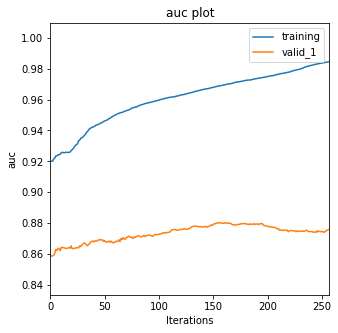

In [26]:
preds, best = LGB_STRATAKFOLD_BINA(5, X_tr, X_te, 'auc', tr['Pclass'])

In [27]:
final = np.where(preds>0.5, 1, 0)
final[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [28]:
len(final)

418

In [29]:
te.shape

(418, 12)

In [30]:
submission = pd.DataFrame()
submission['PassengerId'] = te['PassengerId']
submission['Survived'] = final

In [31]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [32]:
submission['Survived'].value_counts()

0    273
1    145
Name: Survived, dtype: int64

In [33]:
submission.to_csv("output/submission.csv", index=False)